In [1]:
import collections
from datetime import datetime
import itertools
import logging
import multiprocessing
import os
import random

import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFilter
from PIL import Image
from scipy import ndimage, signal
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from xgboost import XGBClassifier


tf.get_logger().setLevel(logging.ERROR)

# The Problem

The problem is described in detail [here](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-win-prediction). Given the image of a chess board, predict the side (black or white) that is more likely to win the game.

### Helper Functions

In [2]:
def show_image2(image_id=None, what='train'):
    """Show a random or requested image."""
    if image_id is None:
        all_files = os.listdir(what)
        img_file = random.sample(all_files, 1)[0]
        image_id, _ = os.path.splitext(img_file)
    
    label_df = pd.read_csv(f'{what}.csv')
    img = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    img = img.resize((256, 256))
    img_np = np.array(img)
    turn = label_df[label_df['ImageID'] == int(image_id)].iloc[0, 1]
    label = label_df[label_df['ImageID'] == int(image_id)].iloc[0, 2]
    return img, img_np, label, image_id, turn

In [3]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

Unlike the previous problems, in addition to the current board confuration image, this problem also gives you as input which side is next to move ("turn")

In [7]:
label_df = pd.read_csv('train.csv')
label_df.head()

,ImageID,turn,label
0,0,black,black
1,1,black,white
2,2,black,white
3,3,black,white
4,4,white,white


Label : white
Turn : black


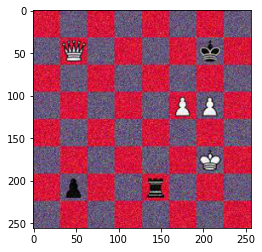

In [8]:
img, img_np, label, image_id, turn = show_image2(11)
plt.imshow(img)
print("Label :", label)
print("Turn :", turn)

# Using Neural Networks and XGBoost

Using the pretrained model from the [ML solution](https://github.com/keyapandia123/ds/blob/main/chess/chess_config.ipynb) to problem 3 ([chess configuration](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-configuration)) to produce a configuration string for the board. Using that configuration string, determine which side is strategically stronger.  First hand-craft features indicating which side is stronger and then use these features for classification.  

### Step 1: Generate configuration string and expanded configuration string for the board

In [4]:
dd = {0:'*', # for background
         1: 'k',
         2: 'p',
         3: 'n',
         4: 'b',
         5: 'r',
         6: 'q',
         7: 'K',
         8: 'P',
         9: 'N',
         10: 'B',
         11: 'R',
         12: 'Q'}

def generate_string(imgbw_np):
    """
    Generate configuration string given an input image.
    
    Given a random or specified image, prodvide the predicted configuration string.
    Run the ML model on the given image, convert the one-hot encoded output into a 
    list of ASCII characters specified as values of the dictionary above. 
    Convert the list of ASCII characters into a predicted configuration string.
    """

    img_block = blockshaped(imgbw_np, 32, 32)
    img_block = np.expand_dims(img_block, -1)
    x = img_block / 255.

    model = keras.models.load_model('my_model_chess_config.h5')

    y_pred_one_hot = model.predict(x)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    y_pred_ascii = [dd[x] for x in y_pred]
    
    
    string = []
    bg_cnt = 0
    for block in range(64):
        if y_pred_ascii[block] == '*':  # background block
            bg_cnt += 1
            if ((block < 63) and (y_pred_ascii[block + 1] != '*')) or (not (block + 1) % 8):
                string.append(str(bg_cnt))
                bg_cnt = 0    
        
        if y_pred_ascii[block] != '*':  # not background block
            string.append(y_pred_ascii[block])
        
        if block < 63 and not (block + 1) % 8:
            string.append('/')
            bg_cnt = 0
                 
    return ''.join(string)

In [5]:
def expand(string):
    """Expand a config string with * for spaces to be exactly of length 64."""
    adj = []
    for c in string:
        if c == '/':
            continue
        if c.isdigit():
            adj = adj + ['*'] * int(c)
        else:
            adj.append(c)
    return ''.join(adj)

Configuration string:  8/1Q4k1/8/5PP1/8/6K1/1p2r3/8
Expanded config string:  *********Q****k**************PP***************K**p**r***********


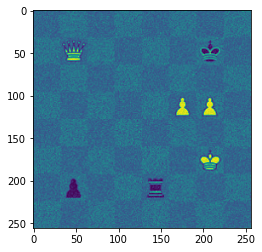

In [9]:
imgbw = img.convert('L')
imgbw = imgbw.resize((256, 256))
imgbw_np = np.array(imgbw)
config = generate_string(imgbw_np)
config_adj = expand(config)

plt.imshow(imgbw)
print("Configuration string: ", config)
print("Expanded config string: ", config_adj)

### Step 2: Using the expanded configuration string, generate a set of features that represent which side is strategically stronger

ALGORITHM:

* From the expanded configuration string, generate a score metric (indicating the total weight of non-pawn pieces), pawn score metric (indicating the total pawn count), aggression metric (indicating how many non-pawn pieces lie on the opposite side of the board), king mobility (no of available/vacant blocks around the king) for each side.
* From the expanded configuration string, generate dictionary of coordinates (row, column) of each non-pawn piece on the board.  
* From the expanded configuration string and dictionary of coordinates, determine which of the pieces (queen, rook, bishop, knight, pawn) is in an attacking position to the opposite king. 
* Based on which pieces are found to be in a position to attack the opposite king (indirect attack, direct attack, and/or current check), update the points metric (total weight of pieces on the board that directly attack or immobilize the opposite king), set of attacking pieces, set of direct attacking pieces (pieces posing an indirect/direct attack on the opposite king), and attacking check metric (indicating whether there is a current check on the opposite king), for each side. 
* Generate a set of features, to be provided to the XGBoost Classifier, as listed below.

FEATURES provided to XGBoost Classifier: 

* black_score: total weight (points) of black non-pawn pieces on the board, 
* white_score: total weight (points) of white non-pawn pieces on the board, 
* black_score - white_score, 
* black_points: total weight (points) of black pieces on the board that directly attack (or immobilize) the white king, 
* white_points: total weight (points) of white pieces on the board that directly attack (or immobilize) the black king, 
* black_points - white_points,
* black_aggr: no of black non-pawn pieces in the white (lower) half of the board, 
* white_aggr: no of white non-pawn pieces in the black (upper) half of the board, 
* black_aggr - white_aggr, 
* black_attacking_check: does the black side pose a current check on the white king?, 
* white_attacking_check: does the white side pose a current check on the black king?, 
* len(black_available): no of vacant blocks around the black king
* len(white_available): no of vacant blocks around the white king,
* len(black_available) - len(white_available), 
* len(black_intervening) - len(white_intervening): difference between the no of intervening pieces blocking a direct attack on each king,
* len(black_attacking): no of black pieces posing an indirect/direct attack (with or without intervening pieces) on the white king, 
* len(white_attacking): no of white pieces posing an indirect/direct attack (with or without intervening pieces) on the black king,
* len(black_attacking) - len(white_attacking), 
* len(black_direct_attacking): no of black pieces on the board that directly attack (or immobilize) the white king (with no intervening pieces),  
* len(white_direct_attacking): no of white pieces on the board that directly attack (or immobilize) the black king (with no intervening pieces),
* len(black_direct_attacking) - len(white_direct_attacking), 
* black_pawn_score: total count of black pawns, 
* white_pawn_score: total count of white pawns,
* black_pawn_score - white_pawn_score, 
* turn: whose turn it is to move next

In [9]:
def piece_scores(config_adj):
    """
    Generate a score metric for each side, indicating the total weight of non-pawn pieces.
    Generate a pawn count/score for each side, indicating the number of pawns for each side.
    """
    black_pawn_score = len([x for x in config_adj if x == 'p'])
    white_pawn_score = len([x for x in config_adj if x == 'P'])
    black_score = 0
    white_score = 0
    score_map = {'q': 9, 'r': 5, 'b': 3, 'n': 3}
    score_map.update({k.upper(): v for k, v in score_map.items()})

    for x in config_adj:
        if x not in score_map:
            continue

        if x.isupper():
            white_score += score_map[x]
        else:
            black_score += score_map[x]
    return black_score, white_score, black_pawn_score, white_pawn_score


def get_piece_coords(config_adj):
    """
    From the expanded configuration string, generate row and column coordinates for each 
    non-pawn piece for both sides.
    """
    all_pieces = ['k', 'q', 'r1', 'r2', 'b1', 'b2', 'n1', 'n2']
    all_pieces.extend([x.upper() for x in all_pieces])
    coords = {key: (None, None) for key in all_pieces}

    for pos, char in enumerate(config_adj):
        if char == '*':
            continue

        row = pos // 8
        col = pos % 8
        if char in 'bBrRnN':
            if coords[f'{char}1'][0]:
                coords[f'{char}2'] = (row, col)
            else:
                coords[f'{char}1'] = (row, col)
        else:
            coords[char] = (row, col)

    return coords


def is_queen_attacking(config_adj, coords, white=True):
    """
    Determine if either queen is in a position to attack the opposite king.
    Is the queen on the same or adjacent row/column/diagonal as the opposite king? 
    - Is there an indirect attack (with one or more intervening pieces) from the queen? 
    - Is there a direct attack (no intervening pieces) from the queen? Does the queen immobilize the king? 
    - Is there a current check from the queen? 
    """
    points = 0
    direct_attacking = set()
    attacking = set()
    intervening = set()
    check = False
    Q_row, Q_col = coords['Q' if white else 'q']
    k_row, k_col = coords['k' if white else 'K']
    queen_to_add = 'Q' if white else 'q'

    if not (Q_row is None):
        # If white queen is in same or adjacent row as black king
        if Q_row == k_row or Q_row == k_row + 1 or Q_row == k_row - 1:
            attacking.add(queen_to_add)
            clear = True
            if Q_row == k_row:
                check = True
            for col in range(min(Q_col, k_col) + 1, max(Q_col, k_col)):
                idx = Q_row * 8 + col
                if config_adj[idx] != '*':
                    intervening.add(idx)
                    clear = False
                    if Q_row == k_row:
                        check = False
            if clear:
                points += 9
                direct_attacking.add(queen_to_add)

        # If white queen is in same or adjacent column as black king
        if Q_col == k_col or Q_col == k_col + 1 or Q_col == k_col - 1:
            attacking.add(queen_to_add)
            clear = True
            if Q_col == k_col:
                check = True
            for row in range(min(Q_row, k_row) + 1, max(Q_row, k_row)):
                idx = row * 8 + Q_col
                if config_adj[idx] != '*':
                    intervening.add(idx)
                    clear = False
                    if Q_col == k_col:
                        check = False
            if clear:
                points += 9
                direct_attacking.add(queen_to_add)

        # If white queen is on same or adjacent diagonal as black king:
        if ((Q_row + Q_col == k_row + k_col) or
                (Q_row + Q_col == k_row + k_col + 1) or
                (Q_row + Q_col == k_row + k_col - 1) or
                (Q_row + Q_col == k_row + k_col + 2) or
                (Q_row + Q_col == k_row + k_col - 2)):
            attacking.add(queen_to_add)
            clear = True
            if Q_row + Q_col == k_row + k_col:
                check = True
            for row in range(min(Q_row, k_row) + 1, max(Q_row, k_row)):
                for col in range(min(Q_col, k_col) + 1, max(Q_col, k_col)):
                    if row + col == Q_row + Q_col:
                        idx = row * 8 + col
                        if config_adj[idx] != '*':
                            intervening.add(idx)
                            clear = False
                            if Q_row + Q_col == k_row + k_col:
                                check = False
            if clear:
                points += 9
                direct_attacking.add(queen_to_add)

                # If white queen is on same or adjacent diagonal as black king
        if ((Q_row - Q_col == k_row - k_col) or
                (Q_row - Q_col == k_row - k_col + 1) or
                (Q_row - Q_col == k_row - k_col - 1) or
                (Q_row - Q_col == k_row - k_col + 2) or
                (Q_row - Q_col == k_row - k_col - 2)):
            attacking.add(queen_to_add)
            clear = True
            if Q_row - Q_col == k_row - k_col:
                check = True
            for row in range(min(Q_row, k_row) + 1, max(Q_row, k_row)):
                for col in range(min(Q_col, k_col) + 1, max(Q_col, k_col)):
                    if row - col == Q_row - Q_col:
                        idx = row * 8 + col
                        if config_adj[idx] != '*':
                            intervening.add(idx)
                            clear = False
                            if Q_row - Q_col == k_row - k_col:
                                check = False
            if clear:
                points += 9
                direct_attacking.add(queen_to_add)

    return points, direct_attacking, attacking, intervening, check


def is_rook_attacking(config_adj, coords, white=True, num=1):
    """
    Determine if either rook is in a position to attack the opposite king.
    Is the rook on the same or adjacent row/column as the opposite king? 
    - Is there an indirect attack (with one or more intervening pieces) from the rook? 
    - Is there a direct attack (no intervening pieces) from the rook? Does the rook immobilize the king?
    - Is there a current check from the rook? 
    """
    points = 0
    direct_attacking = set()
    attacking = set()
    intervening = set()
    check = False
    R_row, R_col = coords[f'R{num}' if white else f'r{num}']
    k_row, k_col = coords['k' if white else 'K']
    rook_to_add = f'R{num}' if white else f'r{num}'

    if not (R_row is None):
        # If white rook is in same or adjacent row as black king
        if R_row == k_row or R_row == k_row + 1 or R_row == k_row - 1:
            attacking.add(rook_to_add)
            clear = True
            if R_row == k_row:
                check = True
            for col in range(min(R_col, k_col) + 1, max(R_col, k_col)):
                idx = R_row * 8 + col
                if config_adj[idx] != '*':
                    intervening.add(idx)
                    clear = False
                    if R_row == k_row:
                        check = False
            if clear:
                points += 5
                direct_attacking.add(rook_to_add)

        # If white rook is in same or adjacent column as black king
        if R_col == k_col or R_col == k_col + 1 or R_col == k_col - 1:
            attacking.add(rook_to_add)
            clear = True
            if R_col == k_col:
                check = True
            for row in range(min(R_row, k_row) + 1, max(R_row, k_row)):
                idx = row * 8 + R_col
                if config_adj[idx] != '*':
                    intervening.add(idx)
                    clear = False
                    if R_col == k_col:
                        check = False
            if clear:
                points += 5
                direct_attacking.add(rook_to_add)

    return points, direct_attacking, attacking, intervening, check


def is_bishop_attacking(config_adj, coords, white=True, num=1):
    """
    Determine if either bishop is in a position to attack the opposite king.
    Is the bishop on the same or adjacent diagonal as the opposite king? 
    - Is there an indirect attack (with one or more intervening pieces) from the bishop? 
    - Is there a direct attack (no intervening pieces) from the bishop? Does the bishop immobilize the king?
    - Is there a current check from the bishop? 
    """
    points = 0
    direct_attacking = set()
    attacking = set()
    intervening = set()
    check = False
    B_row, B_col = coords[f'B{num}' if white else f'b{num}']
    k_row, k_col = coords['k' if white else 'K']
    bishop_to_add = f'B{num}' if white else f'b{num}'

    if not (B_row is None):
        # If white bishop is on same or adjacent diagonal as black king:
        if ((B_row + B_col == k_row + k_col) or
                (B_row + B_col == k_row + k_col + 1) or
                (B_row + B_col == k_row + k_col - 1) or
                (B_row + B_col == k_row + k_col + 2) or
                (B_row + B_col == k_row + k_col - 2)):
            attacking.add(bishop_to_add)
            clear = True
            if B_row + B_col == k_row + k_col:
                check = True
            for row in range(min(B_row, k_row) + 1, max(B_row, k_row)):
                for col in range(min(B_col, k_col) + 1, max(B_col, k_col)):
                    if row + col == B_row + B_col:
                        idx = row * 8 + col
                        if config_adj[idx] != '*':
                            intervening.add(idx)
                            clear = False
                            if B_row + B_col == k_row + k_col:
                                check = False
            if clear:
                points += 3
                direct_attacking.add(bishop_to_add)

        # If white bishop is on same or adjacent diagonal as black king
        if ((B_row - B_col == k_row - k_col) or
                (B_row - B_col == k_row - k_col + 1) or
                (B_row - B_col == k_row - k_col - 1) or
                (B_row - B_col == k_row - k_col + 2) or
                (B_row - B_col == k_row - k_col - 2)):
            attacking.add(bishop_to_add)
            clear = True
            if B_row - B_col == k_row - k_col:
                check = True
            for row in range(min(B_row, k_row) + 1, max(B_row, k_row)):
                for col in range(min(B_col, k_col) + 1, max(B_col, k_col)):
                    if row - col == B_row - B_col:
                        idx = row * 8 + col
                        if config_adj[idx] != '*':
                            intervening.add(idx)
                            clear = False
                            if B_row - B_col == k_row - k_col:
                                check = False
            if clear:
                points += 3
                direct_attacking.add(bishop_to_add)

    return points, direct_attacking, attacking, intervening, check


def is_pawn_attacking(config_adj, coords, white=True):
    """
    Determine if a pawn is in a position to attack the opposite king.
    Is the pawn at most two rows and two columns away from the opposite king? 
    - Is there a direct attack from the pawn? Does the pawn immobilize the king?
    - Is there a current check from the pawn? 
    """
    points = 0
    direct_attacking = set()
    attacking = set()
    intervening = set()
    check = False
    k_row, k_col = coords['k' if white else 'K']
    pawn_to_add = 'P' if white else 'p'

    # Is white pawn in attacking position?
    if white: 
        Rmin = k_row
        Rmax = min(k_row + 2, 7) + 1
    else: 
        Rmin = max(0, k_row - 2)
        Rmax = k_row + 1
    for row in range(Rmin, Rmax):
        for col in range(max(0, k_col - 2), min(k_col + 2, 7) + 1):
            idx = row * 8 + col
            if config_adj[idx] == pawn_to_add:
                points += 1
                attacking.add(pawn_to_add)
                direct_attacking.add(pawn_to_add)
    
     
    # Does white pawn pose an immediate check? 
    if white and (k_row != 7):
        row = k_row + 1
    elif not white and (k_row != 0):
        row = k_row - 1
    if (white and (k_row != 7)) or (not white and (k_row != 0)):
        if k_col == 0:
            col = 1
            idx = row * 8 + col
            if config_adj[idx] == pawn_to_add:
                check = True
        elif k_col == 7:
            col = 6
            idx = row * 8 + col
            if config_adj[idx] == pawn_to_add:
                check = True
        else: 
            col1 = k_col - 1
            col2 = k_col + 1
            idx1 = row * 8 + col1
            idx2 = row * 8 + col2
            if config_adj[idx1] == pawn_to_add or config_adj[idx2] == pawn_to_add:
                check = True
    

    return points, direct_attacking, attacking, intervening, check


def is_knight_attacking(coords, white=True, num=1):
    """
    Determine if either knight is in a position to attack the opposite king.
    Is the knight placed at most three rows and at most three columns away from the opposite king? 
    - Is there a direct attack from the knight?  Does the knight immobilize the king?  
    - Is there a current check from the knight? 
    """
    points = 0
    direct_attacking = set()
    attacking = set()
    intervening = set()
    attacking_check = 0
    check = False
    N_row, N_col = coords[f'N{num}' if white else f'n{num}']
    k_row, k_col = coords['k' if white else 'K']
    knight_to_add = f'N{num}' if white else f'n{num}'

    if not (N_row is None):
        # If white knight is 3 rows or less and 3 columns or less away from the black king:
        if abs(N_row - k_row) <= 3 and abs(N_col - k_col) <= 3:
            points += 3
            attacking.add(knight_to_add)
            direct_attacking.add(knight_to_add)

        if abs(N_row - k_row) + abs(N_col - k_col) == 3:
            attacking_check = 1

    return points, direct_attacking, attacking, intervening, attacking_check


def calculate_availability(config_adj, coords, white=True):
    """
    Determine a measure of mobility of the king. 
    Determine number of blank squares around each king.
    """
    full_set = set()
    unavailable = set()
    K_row, K_col = coords['K' if white else 'k']

    for row in range(max(0, K_row - 1), min(K_row + 1, 7) + 1):
        for col in range(max(0, K_col - 1), min(K_col + 1, 7) + 1):
            idx = row * 8 + col
            full_set.add(idx)
            if config_adj[idx] != '*':
                unavailable.add(idx)
    return full_set.difference(unavailable)


def calculate_aggression(config_adj, white=True):
    """
    Determine a measure of aggression of either side.
    Determine a count of non-pawn pieces of each side that have 
    penetrated into the opposite half of the board.
    """
    aggr = 0
    pawn_to_add = 'P' if white else 'p'

    if white: 
        for pos, char in enumerate(config_adj[:32]):
            if char.isupper() and char != pawn_to_add:
                aggr += 1
                
    if not white: 
        for pos, char in enumerate(config_adj[32:]):
            if char.islower() and char != pawn_to_add:
                aggr += 1
    return aggr


def calculate_features(im_id, what='train', to_print=False, for_LGBM=False):
    """
    Generate features that indicate which side (black or white) is stronger
    """
    img, img_np, label, image_id, turn = show_image2(im_id)
    imgbw = img.convert('L')
    imgbw = imgbw.resize((256, 256))
    imgbw_np = np.array(imgbw)

    config = generate_string(imgbw_np)
    config_adj = expand(config)

    coords = get_piece_coords(config_adj)
    black_score, white_score, black_pawn_score, white_pawn_score = piece_scores(config_adj)

    # Determine white points.
    white_retvals = [
        is_queen_attacking(config_adj, coords, white=True),
        is_rook_attacking(config_adj, coords, white=True, num=1),
        is_rook_attacking(config_adj, coords, white=True, num=2),
        is_bishop_attacking(config_adj, coords, white=True, num=1),
        is_bishop_attacking(config_adj, coords, white=True, num=2),
        is_knight_attacking(coords, white=True, num=1),
        is_knight_attacking(coords, white=True, num=2),
        is_pawn_attacking(config_adj, coords, white=True),
    ]
    white_available = calculate_availability(config_adj, coords, white=True)
    white_aggr = calculate_aggression(config_adj, white=True)

    white_points = sum([x[0] for x in white_retvals])
    white_direct_attacking = set.union(*[x[1] for x in white_retvals])
    white_attacking = set.union(*[x[2] for x in white_retvals])
    white_intervening = set.union(*[x[3] for x in white_retvals])
    white_attacking_check = 1 if any([x[4] for x in white_retvals]) else 0


    # Determine black points.
    black_retvals = [
        is_queen_attacking(config_adj, coords, white=False),
        is_rook_attacking(config_adj, coords, white=False, num=1),
        is_rook_attacking(config_adj, coords, white=False, num=2),
        is_bishop_attacking(config_adj, coords, white=False, num=1),
        is_bishop_attacking(config_adj, coords, white=False, num=2),
        is_knight_attacking(coords, white=False, num=1),
        is_knight_attacking(coords, white=False, num=2),
        is_pawn_attacking(config_adj, coords, white=False),
    ]
    black_available = calculate_availability(config_adj, coords, white=False)
    black_aggr = calculate_aggression(config_adj, white=False)

    black_points = sum([x[0] for x in black_retvals])
    black_direct_attacking = set.union(*[x[1] for x in black_retvals])
    black_attacking = set.union(*[x[2] for x in black_retvals])
    black_intervening = set.union(*[x[3] for x in black_retvals])
    black_attacking_check = 1 if any([x[4] for x in black_retvals]) else 0

    if to_print:
        plt.imshow(img)
        print("Config String: ", config)
        
        print("Black score = ", black_score)
        print("White score = ", white_score)

        print("Black points = ", black_points)
        print("White points = ", white_points)

        print("Black pawn count = ", black_pawn_score)
        print("White pawn count = ", white_pawn_score)

        print("Black attacking = ", black_direct_attacking)
        print("White attacking = ", white_direct_attacking)
            
        print("Intervening for black: ", black_intervening)
        print("Intervening for white: ", white_intervening)

        print("White under check: ", black_attacking_check)
        print("Black under check: ", white_attacking_check)
        
        print("Black aggression = ", black_aggr)
        print("White aggression = ", white_aggr)

    to_return_LGBM = (
        label, black_score, white_score, black_score - white_score, black_points, white_points, black_points - white_points,
        black_aggr, white_aggr, black_aggr - white_aggr, black_attacking_check, white_attacking_check, len(black_available),
        len(white_available),
        len(black_available) - len(white_available), len(black_intervening) - len(white_intervening),
        len(black_attacking), len(white_attacking),
        len(black_attacking) - len(white_attacking), len(black_direct_attacking), len(white_direct_attacking),
        len(black_direct_attacking) - len(white_direct_attacking), black_pawn_score, white_pawn_score,
        black_pawn_score - white_pawn_score, turn)

    if for_LGBM:
        return to_return_LGBM

    to_return_manual = (label, black_score, white_score, black_points, white_points, config_adj,
                        black_aggr, white_aggr, black_attacking_check, white_attacking_check, black_available,
                        white_available,
                        black_intervening, white_intervening, black_attacking, white_attacking,
                        black_direct_attacking, white_direct_attacking,
                        black_pawn_score, white_pawn_score, turn)

    return to_return_manual
                

Turn : white
Config String:  3rr2k/pp5p/2q3p1/2p5/2Qb1p2/5K2/P1P3PP/1R3B1R
Black score =  22
White score =  22
Black points =  18
White points =  9
Black pawn count =  6
White pawn count =  4
Black attacking =  {'r1', 'p', 'b1', 'q'}
White attacking =  {'Q'}
Intervening for black:  set()
Intervening for white:  {55, 15}
White under check:  1
Black under check:  0
Black aggression =  1
White aggression =  0


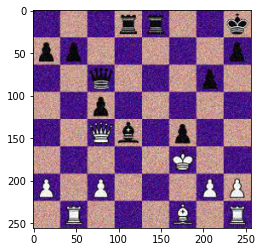

In [10]:
img, img_np, label, image_id, turn = show_image2(7)
print("Turn :", turn)
_ = calculate_features(im_id=7, what='train', to_print=True)

### Step 3: Classification using the generated features

#### Using XGBoost for classification

In [11]:
def preparing_data_for_boosting_clf(what='train', n=1000):
    """
    Prepare input feature dataframe and output label vector to be used by a boosting tree classifier
    """
    y = []
    
    X = []
    
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    train = random.sample(all_files, n)

    for file in train:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        out = calculate_features(im_id, what, for_LGBM=True)
        if out[-1] == 'black':
            turn_binary = 0
        else:
            turn_binary = 1
        x = list(out[1:-1])
        x.append(turn_binary)
        X.append(x)
        y.append(out[0])
    
    X_df = pd.DataFrame(X)
   
    X_df.columns = ['black_score', 'white_score', 'diff1', 'black_points', 'white_points', 'diff2', 
                    'aggr_black', 'aggr_white', 'diff3', 'black_attacking_check', 'white_attacking_check', 
                    'available_black', 'available_white', 'diff4', 'diff5', 'black_attacking', 'white_attacking', 'diff6', 
                    'black_direct_attacking', 'white_direct_attacking', 'diff7', 'black_pawn_score', 'white_pawn_score', 'diff8', 'turn']
    return X_df, y
    
    

In [12]:
X_train_df, y_train = preparing_data_for_boosting_clf(what='train', n=40000)

In [13]:
X_test_df, y_test = preparing_data_for_boosting_clf(what='val', n=4000)

#### Using XGBoost

In [14]:
clf = XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=700)
clf.fit(X_train_df, y_train, eval_metric='error')

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
y_pred = clf.predict(X_test_df)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='white')
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

Accuracy:  0.98375
F1:  0.9858603437024146
Confusion Matrix: 
[[1669   39]
 [  26 2266]]


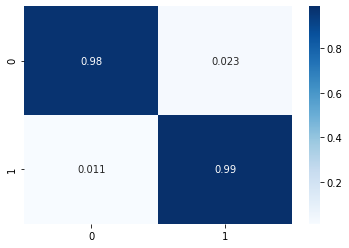

In [16]:
print("Accuracy: ", accuracy)
print("F1: ", f1)
print("Confusion Matrix: ")
print(cm)
_ = sns.heatmap(cm_norm, annot=True, cmap='Blues')

In [17]:
Imp_df = pd.DataFrame(clf.feature_importances_).T

Imp_df.columns = ['black_score', 'white_score', 'diff1', 'black_points', 'white_points', 'diff2', 
                    'aggr_black', 'aggr_white', 'diff3', 'black_attacking_check', 'white_attacking_check', 
                    'available_black', 'available_white', 'diff4', 'diff5', 'black_attacking', 'white_attacking', 'diff6', 
                    'black_direct_attacking', 'white_direct_attacking', 'diff7', 'black_pawn_score', 'white_pawn_score', 'diff8', 'turn']
Imp_df.index = ['Importance']
print(Imp_df.T.sort_values(by='Importance', ascending = False))

                        Importance
diff7                     0.418088
diff6                     0.067134
diff3                     0.066325
turn                      0.063465
diff1                     0.043058
diff2                     0.037205
white_attacking_check     0.031286
black_attacking_check     0.028745
diff8                     0.026467
white_score               0.018357
black_score               0.018257
diff5                     0.016349
white_attacking           0.013713
white_points              0.013549
black_points              0.013427
available_black           0.013426
white_pawn_score          0.013280
aggr_black                0.012964
black_attacking           0.012921
available_white           0.012632
aggr_white                0.012311
diff4                     0.012221
black_pawn_score          0.012143
black_direct_attacking    0.011558
white_direct_attacking    0.011119
